In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 689.5 kB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from keras.layers import Dense, Dropout, GlobalAveragePooling2D 
#from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

#from keras.applications import *

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from skopt.space import Categorical
from skopt import gp_minimize

import bz2
import pickle
import _pickle as cPickle

import matplotlib.pyplot as plt

## Carregamento de dados

In [ ]:
# DEFINE FUNÇÃO PARA DESCOMPRIMIR DADOS
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

In [ ]:
# CONEXÃO COM GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
BASE_PATH = './drive/MyDrive/TCC'


In [ ]:
# CARREGA E DESCOMPRIME DADOS
with open(f'{BASE_PATH}/features.pbz2', 'rb') as file:
  X = decompress_pickle(file)

with open(f'{BASE_PATH}/labels.pbz2', 'rb') as file:
  Y = decompress_pickle(file)

## Pré-processamento

In [ ]:
# REDIMENSIONA IMAGENS
X = tf.keras.preprocessing.image.smart_resize(
    X, (224,224), interpolation='bilinear'
)

In [ ]:
# GARANTE TIPO DOS DADOS
X = X.astype('float32')

In [ ]:
# DIVIDE DATASET EM TREINO E TESTE
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

## Tranferência de aprendizado

In [ ]:
# FUNÇÃO PARA CRIAÇÃO RECORRENTE DE MODELOS
def create_model(name, backbone,
                 input_shape, preprocess,
                 dropout, optimizer, loss, projection):

# BACKBONE
  base_model = backbone(
      weights="imagenet",
      input_shape=input_shape,
      include_top=False
  )

# CONGELA CAMADAS DO BACKBONE
  base_model.trainable = False

# INPUT DO MODELO
  inputs = keras.Input(shape=input_shape)

# PRÉ-PROCESSAMENTO ESPCÍFICO PARA O BACKBONE SELCIONADO
  inputs = preprocess(
     inputs, data_format=None)

# ADICIONA CAMADAS DE CLASSIFICAÇÃO PARA NOVA TAREFA
  x = base_model(inputs, training=False)
  x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
  x = Dense(160,activation="relu", name="projection_1")(x)
  if projection>1:
    x = Dense(64,activation="relu", name="projection_2")(x)
    if projection ==3:
      x = Dense(32,activation="relu", name="projection_3")(x)
  x = Dropout(dropout)(x)
  outputs = Dense(1,activation="sigmoid")(x)
  model = keras.Model(inputs, outputs)

# RENOMEIA MODELO
  model._name = name
  
# RENOMEIA CAMADA
  model.get_layer(index=1)._name = 'backbone'

# COMPILA MODELO
  model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy", "Recall", "Precision"]
  )

  return model 

In [ ]:
models = {
    # 'MobileNet': 
    #       {'backbone': tf.keras.applications.MobileNetV2,
    #       'preprocess': tf.keras.applications.mobilenet_v2.preprocess_input
    #        },
          
          'VGG16' : 
          {'backbone': tf.keras.applications.VGG16,
          'preprocess': tf.keras.applications.vgg16.preprocess_input 
          }, 
          
    #       'Xception' : 
    #       {'backbone' : tf.keras.applications.Xception,
    #       'preprocess' : tf.keras.applications.xception.preprocess_input
    #       }, 
          
          # 'ResNet' : 
          # {'backbone' : tf.keras.applications.ResNet50,
          # 'preprocess' : tf.keras.applications.resnet.preprocess_input 
          # },
          
          # 'InceptionResNetV2': 
          # {'backbone' : tf.keras.applications.InceptionResNetV2,
          # 'preprocess': tf.keras.applications.inception_resnet_v2.preprocess_input
          # },
          
          # 'DenseNet121' : 
          # {'backbone': tf.keras.applications.DenseNet121,
          # 'preprocess' : tf.keras.applications.densenet.preprocess_input 
          # },
          
          # 'EfficientNetB2' : 
          # {'backbone' : tf.keras.applications.EfficientNetB2,
          # 'preprocess': tf.keras.applications.efficientnet.preprocess_input
          # }
}                             

## Definição de Baseline

### Otimização Bayesiana


In [ ]:
EPOCHS = 15
OPTIMIZATION_RUNS = 10

In [ ]:
# ESPAÇO DE PARÂMETROS A SER EXPLORADO`
params_space = [(0.05, 0.5), 
        ('adam', 'sgd'),
        (1e-3, 1e-1, 'log-uniform'),
        ('hinge', 'binary_crossentropy', 'binary_focal_crossentropy'),
        (16, 32, 64),
        Categorical([1,255]),
        (1,2,3)
       ]

In [ ]:
# FUNÇÃO PARA CRIAÇÃO DE MODELOS E EXPLORAÇÃO DO ESPAÇO DE HIPERPARÂMETROS
def create_optimized_model(params, name, backbone, preprocess) : 
  
  print(params)

  dropout = params[0] 
  optimizer = params[1] 
  learning_rate = params[2]
  loss = params[3]
  batch_size = params[4]
  scale = params[5]
  projection = params[6]

  if optimizer == 'adam':
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
  elif optimizer == 'sgd':
    opt = keras.optimizers.SGD(learning_rate=learning_rate)

  model = create_model(
      name=name,
        backbone=backbone,
        preprocess=preprocess,
        input_shape = (224,224,3),
        dropout=dropout,
        optimizer=optimizer,
        loss=loss,
        projection=projection
        )
  
  return model

In [ ]:
# FUNÇÃO AUXILIAR PARA PARAMETRIZAR BACKBONE A SER TREINADO E AVALIÁ-LO
def evaluate_network(params, name, backbone, preprocess):
    
    batch_size = params[4]
    scale = params[5]

    model = create_optimized_model(params, name, backbone, preprocess)
    
    model.fit(X_train/scale, 
              y_train,
              epochs=EPOCHS,
              batch_size=batch_size,
              validation_split=0.2,
              verbose=2
              )   

    y_pred = model.predict(X_test/scale)

    loss, acc, recall, precision = model.evaluate(X_test/scale, y_test)

    return -roc_auc_score(y_test, y_pred)

In [ ]:
# EXPLORA ESPAÇO DE PARÂMETROS PARA ENCONTRAR MELHOR ROC AUC
for key,value in models.items():
  
  np.random.seed(42)
  tf.random.set_seed(42)

  name = key
  backbone = models[key]['backbone']
  preprocess = models[key]['preprocess']
  
  print(key)

  optimum = gp_minimize(lambda x: 
                      evaluate_network(x, name, backbone, preprocess),
                      params_space,n_calls=OPTIMIZATION_RUNS
                    )
  
  models[key]['optimized'] = optimum
  optimum = optimum['x'].append(optimum['fun'])
  
  df = pd.DataFrame(optimum)
  
  df.to_csv(f'{BASE_PATH}/{key}_optimum.csv')

## Fine Tuning

In [ ]:
FINE_TUNING_EPOCHS = 5

In [ ]:
# FUNÇÃO PARA EXECUÇÃO DE FINE TUNING RECORRENTE
def fine_tune(model, loss, trainable_layers):
  # SELECIONA CAMADA DE BACKBONE
  backbone = model.get_layer('backbone')
  
  # TORNA BACKBONE TREINÁVEL
  backbone.trainable = True
  
  # SELECIONA CAMADAS QUE PERMANECERÃO TREINÁVEIS
  for layer in backbone.layers[:- trainable_layers]:
      layer.trainable = False
      # CONGELA CAMADAS DE BN
      if isinstance(layer, keras.layers.BatchNormalization):
          layer._per_input_updates = {}

  model.compile(
    optimizer=keras.optimizers.Adam(10e-7), 
    loss=loss,
    metrics=["accuracy", "Recall", "Precision"],
  )
  
  return model

In [ ]:
# TREINA MODELOS COM PARÂMETROS OTIMIAZADOS NOVAMENTE DEVIDO PROBLEMAS EM CARREGAR MODELOS SALVOS
for key, value in models.items():

  np.random.seed(1)
  tf.random.set_seed(1)

  params = models[key]['params']

  dropout = params[0] 
  optimizer = params[1] 
  learning_rate = params[2]
  loss = params[3]
  batch_size = params[4]
  scale = params[5]
  projection = params[6]

  if optimizer == 'adam':
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
  elif optimizer == 'sgd':
    opt = keras.optimizers.SGD(learning_rate=learning_rate)

  print(f'initizalizing {key.upper()} model')
  
  model = create_model(
      name=key,
      backbone=models[key]['backbone'],
      preprocess=models[key]['preprocess'],
      input_shape = (224,224,3),
      projection=projection,
      dropout=dropout,
      optimizer=optimizer,
      loss=loss
    )
  
  model_hist = model.fit( X_train/scale, y_train, epochs=EPOCHS, 
                         batch_size=batch_size,
                         validation_split=0.25, verbose=1                         
                           )

# FINE TUNNING 
  model_tuned = fine_tune(model, loss, 10)
    
  model_tuned_hist = model_tuned.fit(
      X_train,
      y_train,fin
      epochs=FINE_TUNING_EPOCHS,
      validation_split=0.25
      )

  model_eval = model_tuned.evaluate(X_test/scale, y_test)

  models[key]['model_tuned'] = model_tuned
  models[key]['model_tuned_hist'] = model_tuned_hist.history
  models[key]['evaluation'] = model_eval
  
  hist = pd.DataFrame(model_tuned_hist.history)
  eval = pd.DataFrame(model_eval)

  hist.to_csv(f'{BASE_PATH}/{key}_tuned_hist.csv', index=False)
  eval.to_csv(f'{BASE_PATH}/{key}_tuned_eval.csv', index=False)

In [ ]:
def plot_metrics(models, metrics, history_name):
  for metric in metrics:
    plt.figure(figsize=(15,6))

    for key in models.keys():
      plt.plot(models[key][history_name].history[metric], linewidth=.8)
      
    plt.legend([f'{key}' for key in models.keys() ], loc="upper left")

    plt.title(f'{metric.upper()}');

In [ ]:
def plot_metrics(models, metrics, history_name):
  for metric in metrics:
    plt.figure(figsize=(15,6))

    for key in models.keys():
      plt.plot(models[key][history_name].history[metric], linewidth=.8)
      
    plt.legend([f'{key}' for key in models.keys() ], loc="upper left")

    plt.title(f'{metric.upper()}');

In [ ]:
plot_metrics(models=models, metrics=metrics, history_name='model_hist')

In [ ]:
#models['MobileNet']['params'] = [0.22, 'adam', 0.003, 'binary_crossentropy', 32, 255, 3]
models['VGG16']['params'] =  [0.41, 'adam', 0.036, 'binary_focal_crossentropy', 32, 1, 2]
#models['Xception']['params'] = [0.20, 'adam', 0.020, 'binary_crossentropy', 32, 255, 1]
models['ResNet']['params'] =  [0.41, 'adam', 0.036, 'binary_focal_crossentropy', 32, 1, 2]
#models['InceptionResNetV2']['params'] = [0.22, 'adam', 0.003, 'binary_crossentropy', 32, 255, 3]
#models['DenseNet121']['params'] = [0.20, 'adam', 0.020, 'binary_crossentropy', 32, 1, 1]
models['EfficientNetB2']['params'] =  [0.13, 'adam', 0.002, 'hinge', 32, 1, 2]

In [ ]:
for key in models.keys():
     #print(f'{key}: {models[key]["model_hist"].history}')
     print(f'{key}: {models[key]["evaluation"]}')

MobileNet: [0.8390697836875916, 0.6564815044403076, 0.5991735458374023, 0.6209850311279297]
VGG16: [0.16138716042041779, 0.6462963223457336, 0.4834710657596588, 0.6393442749977112]
Xception: [0.7582231760025024, 0.644444465637207, 0.5247933864593506, 0.6225489974021912]
ResNet: [0.15883497893810272, 0.6527777910232544, 0.4028925597667694, 0.6939501762390137]
InceptionResNetV2: [0.6295545697212219, 0.6592592597007751, 0.5681818127632141, 0.6336405277252197]
DenseNet121: [0.17202915251255035, 0.5555555820465088, 0.00826446246355772, 1.0]
EfficientNetB2: [0.15690140426158905, 0.6638888716697693, 0.49380165338516235, 0.6694678068161011]


In [ ]:
for key in models.keys():
     print(f'{key}: {models[key]["evaluation"]}')

MobileNet: [0.835776686668396, 0.6574074029922485, 0.5289255976676941, 0.643216073513031]
VGG16: [0.1677752286195755, 0.5842592716217041, 0.22107438743114471, 0.5977653861045837]
Xception: [0.7594047784805298, 0.6425926089286804, 0.5433884263038635, 0.6144859790802002]
ResNet: [0.17204125225543976, 0.5518518686294556, 0.0, 0.0]
InceptionResNetV2: [0.6335822343826294, 0.6601851582527161, 0.5991735458374023, 0.6263498663902283]
DenseNet121: [0.15664222836494446, 0.6675925850868225, 0.5309917330741882, 0.6606683731079102]
EfficientNetB2: [0.1575203835964203, 0.6638888716697693, 0.5041322112083435, 0.664850115776062]


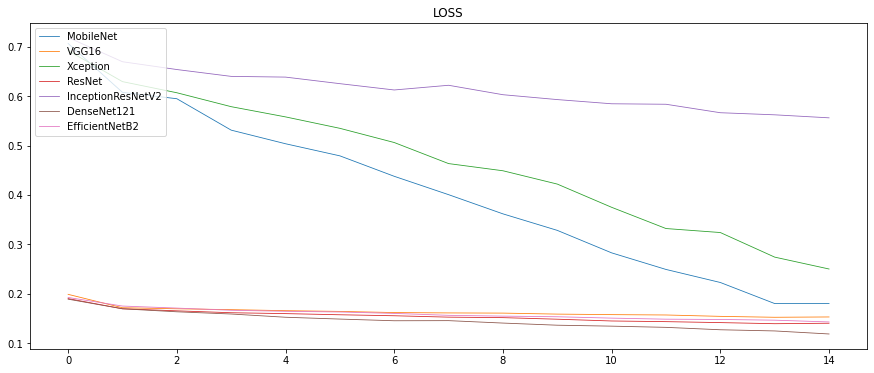

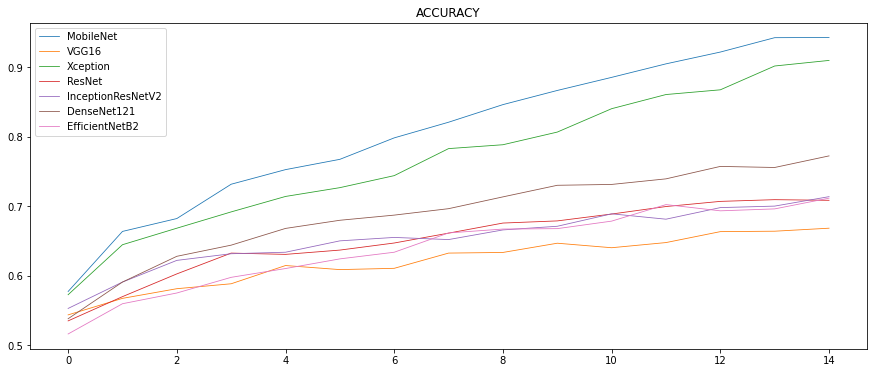

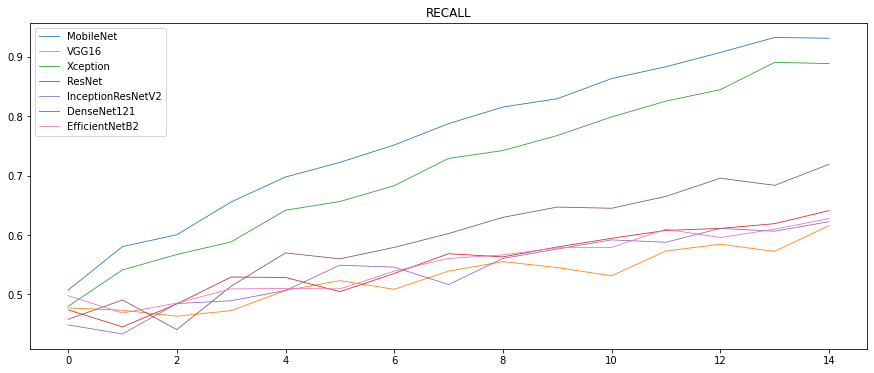

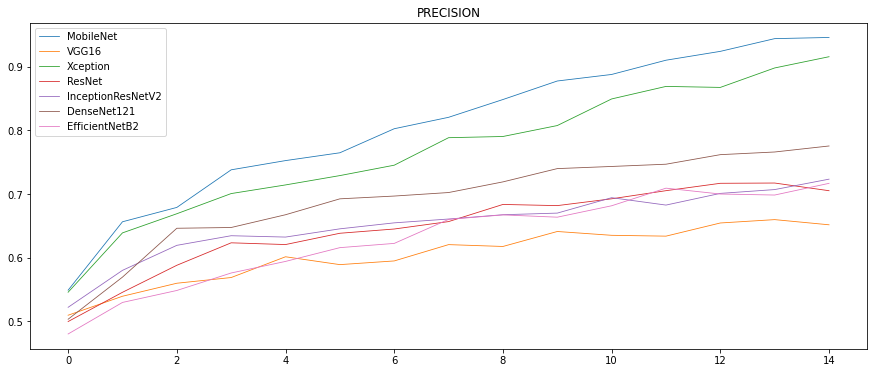

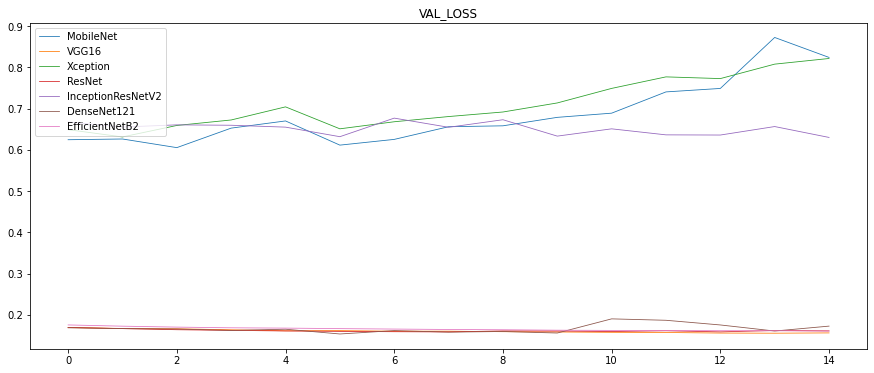

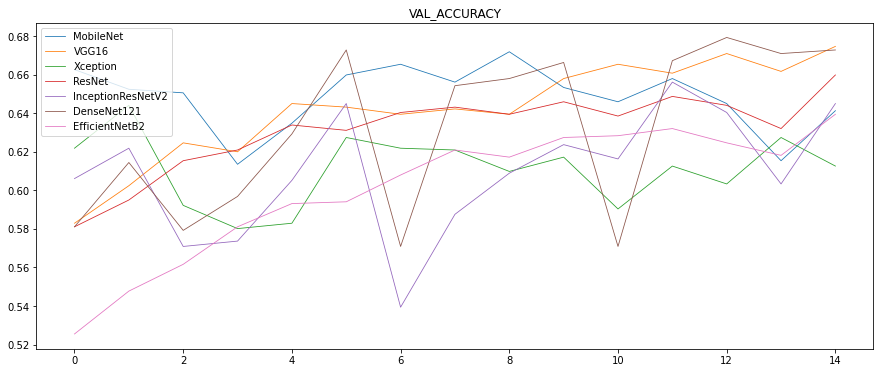

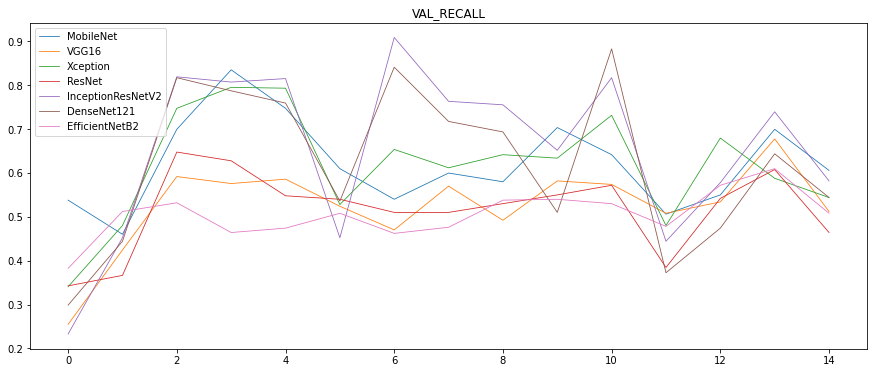

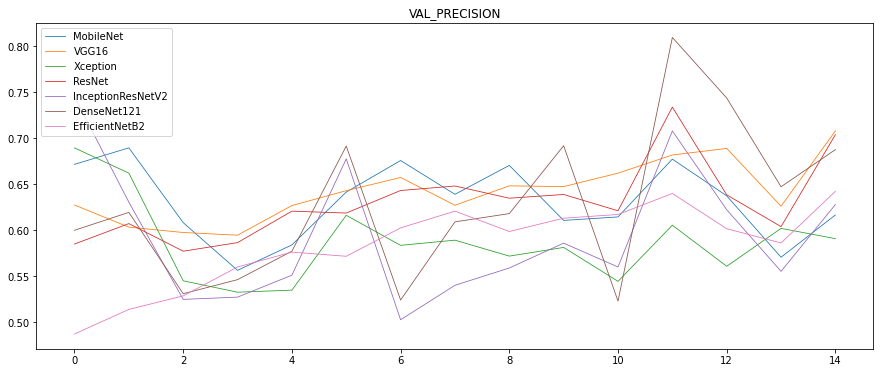

In [ ]:
for metric in metrics:
    plt.figure(figsize=(15,6))

    for key in models.keys():
      plt.plot(models[key]['model_hist'].history[metric], linewidth=.8)
      
    plt.legend([f'{key}' for key in models.keys() ], loc="upper left")

    plt.title(f'{metric.upper()}');

In [ ]:
for key in models.keys():
     print(f'{key}: {models[key]["evaluation"]}')

MobileNet: [0.798245370388031, 0.6638888716697693, 0.5971074104309082, 0.6323851346969604]
VGG16: [0.15956488251686096, 0.6555555462837219, 0.48140496015548706, 0.6581920981407166]
Xception: [0.7619918584823608, 0.6574074029922485, 0.5743801593780518, 0.6289592981338501]
ResNet: [0.16232305765151978, 0.6481481194496155, 0.43388429284095764, 0.6645569801330566]
InceptionResNetV2: [0.6335822343826294, 0.6601851582527161, 0.5991735458374023, 0.6263498663902283]
DenseNet121: [0.15664222836494446, 0.6675925850868225, 0.5309917330741882, 0.6606683731079102]
EfficientNetB2: [0.1575203835964203, 0.6638888716697693, 0.5041322112083435, 0.664850115776062]


In [ ]:
metrics = ['loss', 'accuracy', 'recall', 'precision', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision']

In [ ]:
def plot_metrics(models, metrics, history_name):
  for metric in metrics:
    plt.figure(figsize=(15,6))

    for key in models.keys():
      plt.plot(models[key][history_name].history[metric], linewidth=.8)
      
    plt.legend([f'{key}' for key in models.keys() ], loc="upper left")

    plt.title(f'{metric.upper()}');

In [ ]:
# threshold=0.6

# y_pred_discrete = (y_pred > threshold).astype(int)

# f2 = fbeta_score(y_test, y_pred_discrete, beta=2, average='weighted')

In [ ]:
# accuracy = accuracy_score(y_test,  y_pred>0.8)
# recall= recall_score(y_test,  y_pred>0.8)
# precision = precision_score(y_test,  y_pred>0.8)

# accuracy, recall, precision